In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = 'retina'

def draw_residuals(x, y0, y1, ax=None):
    if ax is None:
        ax = plt
    
    for i in range(len(x)):
        ax.plot([x[i],x[i]],[y0[i],y1[i]], lw=0.5, c="red")

# Boosting
### or: how to be right when you're usually wrong

Brandon Martin-Anderson, February 2017; with great debt to Mark Llorente and Moses Marsh et al.

## Objectives

Morning:
* Decision tree, random forest review
* Boosting without gradient descent
* Gradient-descending using learning rate
* Boosting for classification

Afternooon:
* Adaboost
* Tuning tips
* Partial dependence plots


## The curious case of the arbitrary function

Say we want to learn some latent relationship between `X` and `y`, for which we have some observations:

In [2]:
mystery_process = lambda x: np.sin(x+1)+x/4

x = np.linspace(0, 2*np.pi, num=150) # our scientist in the field poking along
y = mystery_process(x)               # some ineffable mystery of nature

(-1, 2.5)

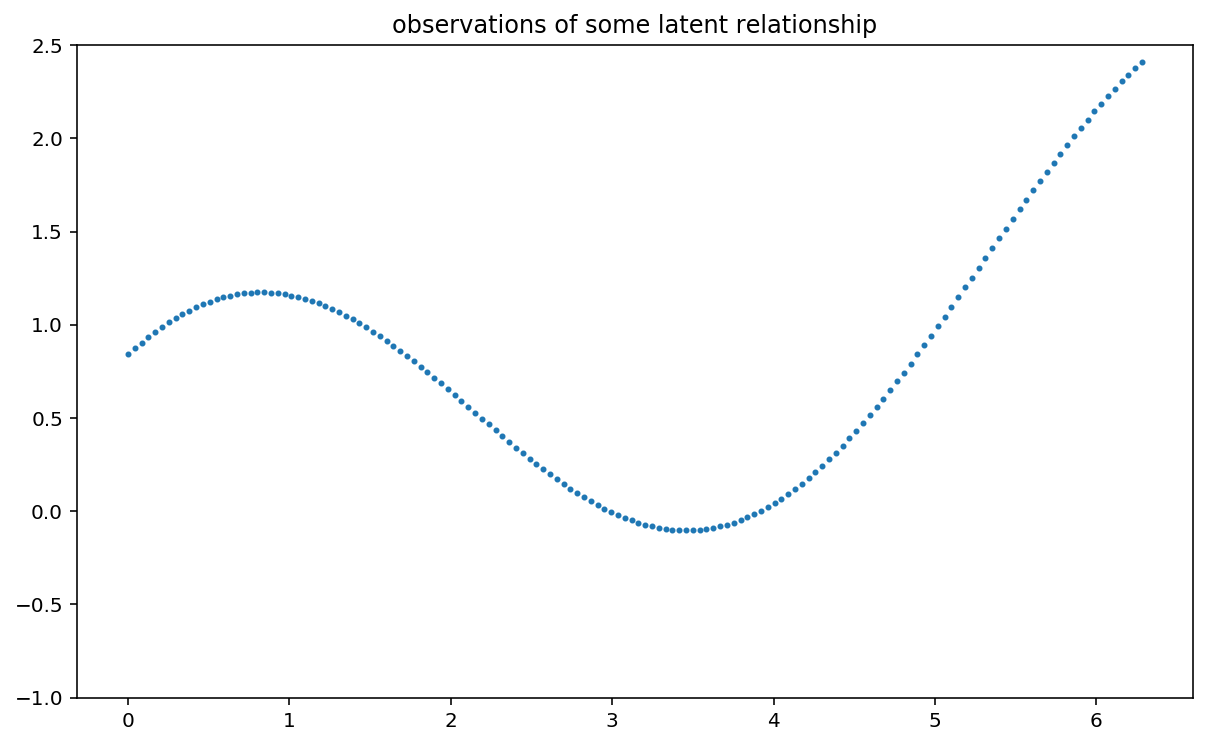

In [3]:
plt.figure(figsize=(10,6))
plt.scatter(x, y, s=4)
plt.title("observations of some latent relationship")
plt.ylim(-1, 2.5)

Jumping ahead for a moment: the relationship we want to express is

$$ f(x) = \sin(x+1) + \frac{x}{4}$$.

But imagine we possess neither the formalism to express that or a means by which to fit the parameters. We're real dumb. Instead, imagine that all we have is the most simple model there is, a **decision tree stump**.

In [13]:
class Stump:
    # assumes x is 1d and ordered
    
    def _get_impurities(self, y):
        n = len(y)
        
        impurities = []
        for i in range(1, n):
            left_impurity = y[:i].var()
            right_impurity = y[i:].var() 
            impurity = (i/n)*left_impurity + ((n-i)/n)*right_impurity
            
            impurities.append( impurity )
        return np.array(impurities)
    
    def fit(self, x, y):
        split_index = np.argmin( self._get_impurities(y) )
        
        self._split = x[split_index]
        self._left = y[:split_index].mean()
        self._right = y[split_index:].mean()
        
    def predict(self, x):
        return np.where( x < self._split, self._left, self._right )

Create the stump model, then fit it.

In [14]:
stump0 = Stump()
stump0.fit( x, y )
yhat = stump0.predict(x)

Let's take a look at how we did.

(-1, 2.5)

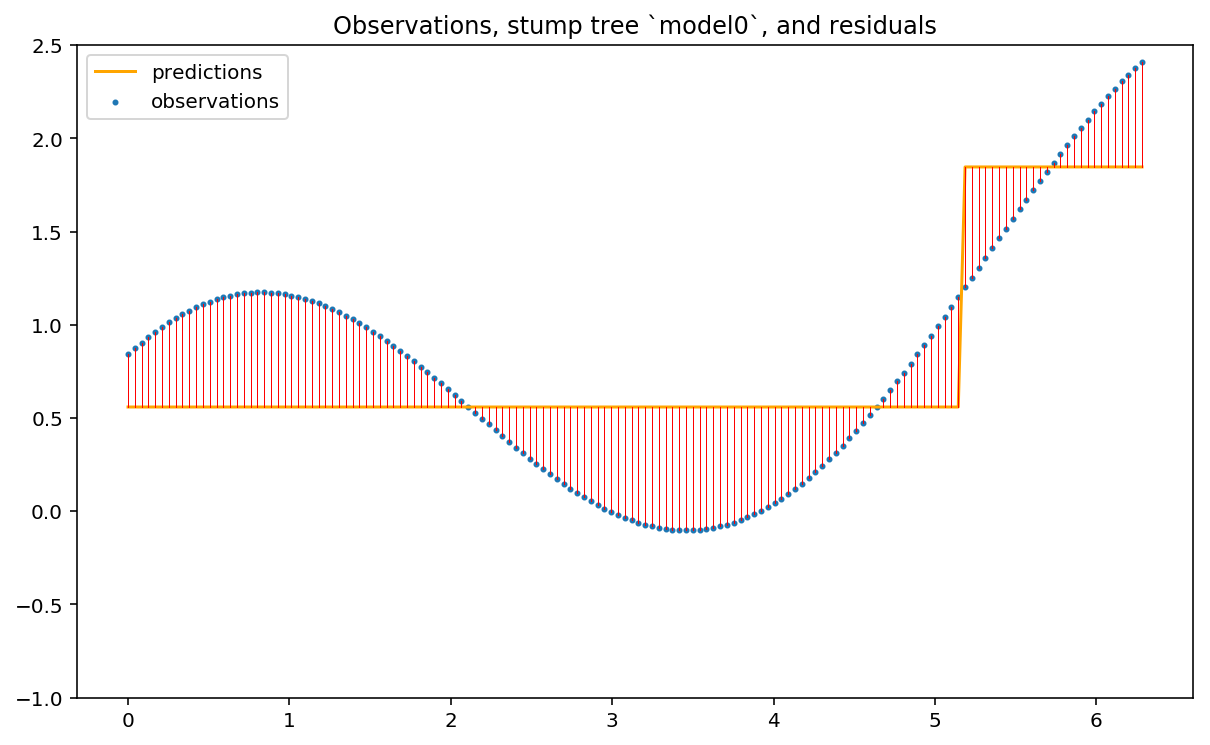

In [15]:
plt.figure(figsize=(10,6))
plt.scatter(x, y, s=4, label="observations")
plt.plot(x, yhat, c="orange", label="predictions")

draw_residuals(x, yhat, y)
plt.legend()
plt.title("Observations, stump tree `model0`, and residuals")
plt.ylim(-1, 2.5)

### Components of error

Recall that mean square error is a sum of:

```MSE = bias^2 + variance + irreducible error```

* What's the irreducible error?
* What's the model variance?
* What's the model bias?

In this case, nearly all of the MSE is from bias. In other words, **this model is wrong a lot**.

A common term for high-bias model is a **weak learner**.

## Learning from what you got wrong

The residual function is just another function. Could we fit a weak learner to **that**?

(-1.5, 1.5)

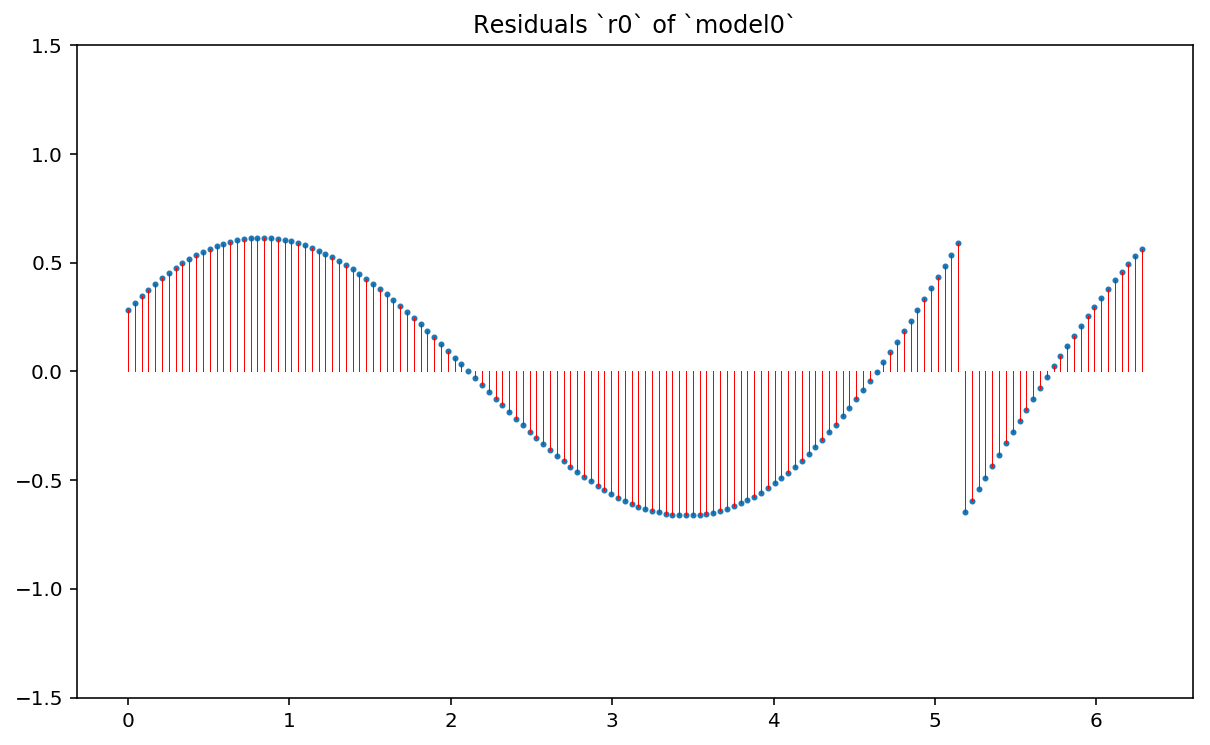

In [16]:
r0 = y - yhat

plt.figure(figsize=(10,6))
plt.scatter(x, r0, s=4)
draw_residuals(x, np.zeros_like(x), r0)
plt.title("Residuals `r0` of `model0`")
plt.ylim(-1.5, 1.5)

In [17]:
stump1 = Stump()
stump1.fit(x, r0)

In [18]:
yhat = stump1.predict(x)

Text(0.5, 1.0, 'Model trained on residuals `r0`, and residuals `r1`')

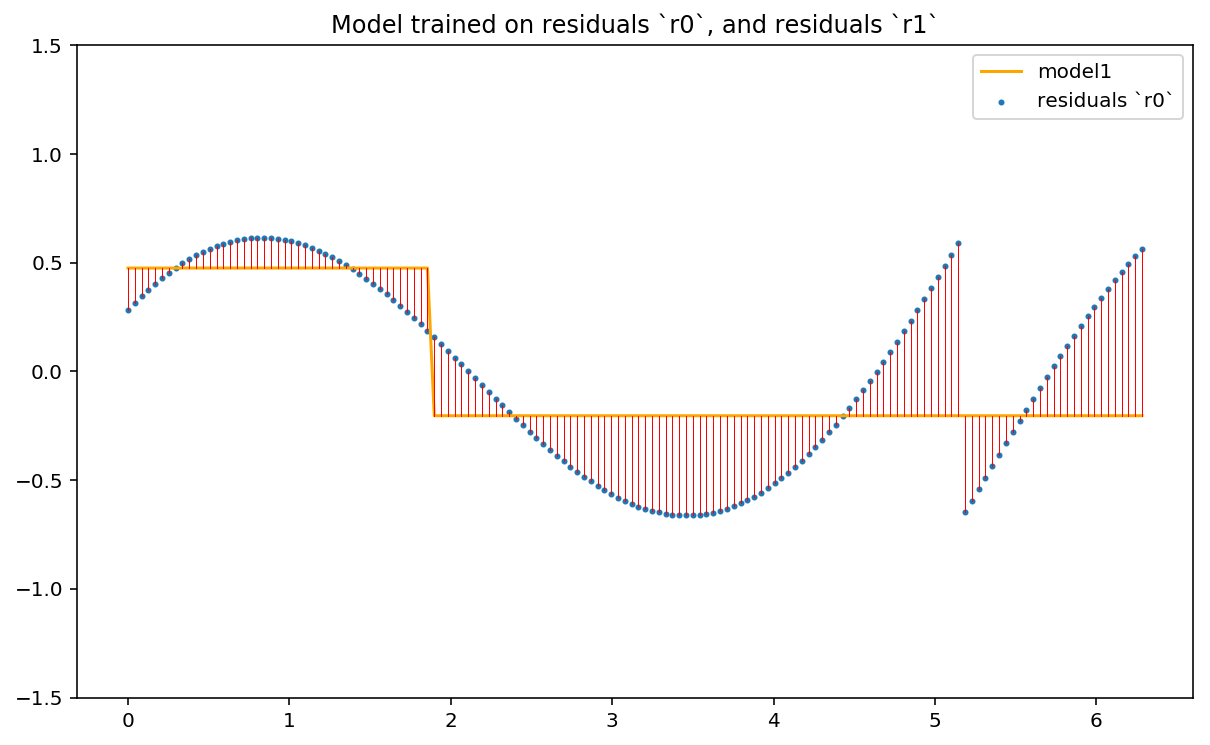

In [19]:
plt.figure(figsize=(10,6))
plt.scatter(x, r0, s=4, label="residuals `r0`")
plt.plot(x, yhat, c="orange", label="model1")
draw_residuals(x, r0, yhat)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.title("Model trained on residuals `r0`, and residuals `r1`")

## Sequential Ensemble

Now we have two models:

1. Make a prediction for `x`.
2. Make a prediction for the _error_ of `x`.

The sum of the two models yields a lower bias than either alone.

In [20]:
yhat = stump0.predict(x) + stump1.predict(x)

Text(0.5, 1.0, 'Ensemble model, and residuals `r1`')

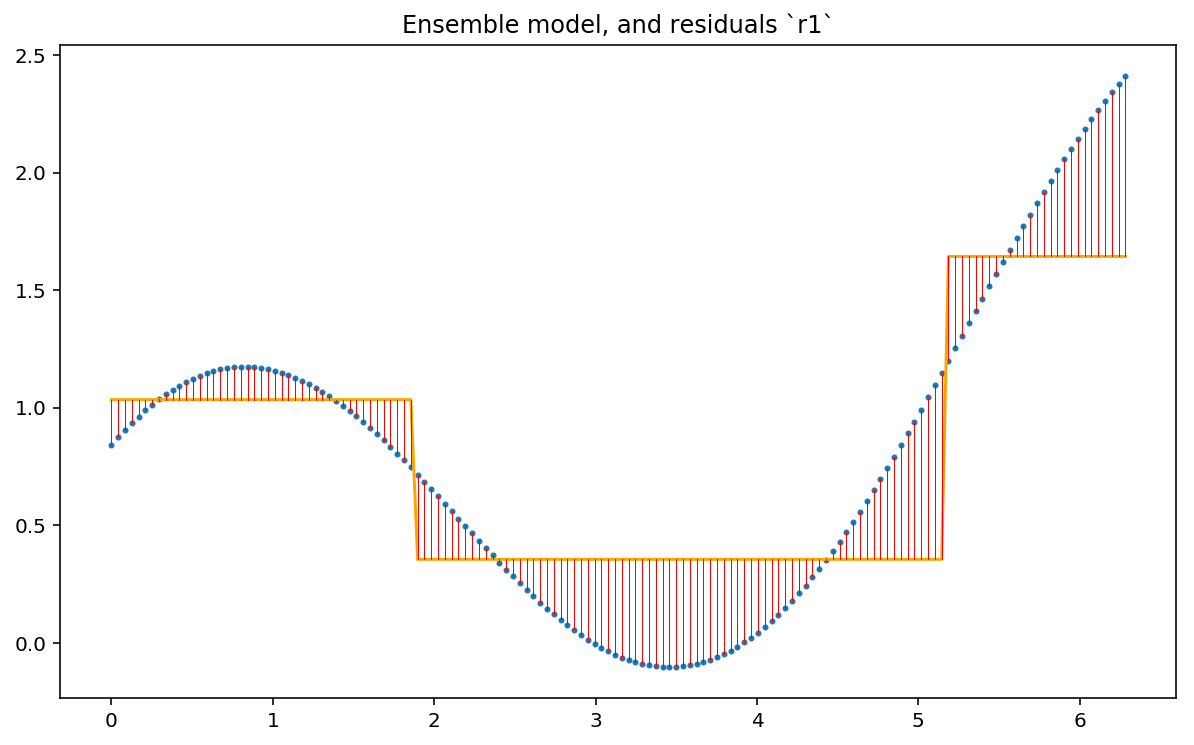

In [22]:
plt.figure(figsize=(10,6))
plt.scatter( x, y, s=4, label="observations" )
plt.plot( x, yhat, c="orange", label="ensemble model" )

draw_residuals(x, yhat, y)

plt.title("Ensemble model, and residuals `r1`")

## Turnt up

There's nothing stopping us from repeating this process.

In [23]:
class SequentialEnsemble:
    def __init__(self):
        self.models = []
        
    def add(self, model):
        self.models.append( model )
        
    def predict(self, x):
        return np.sum( [m.predict(x) for m in self.models], axis=0 )

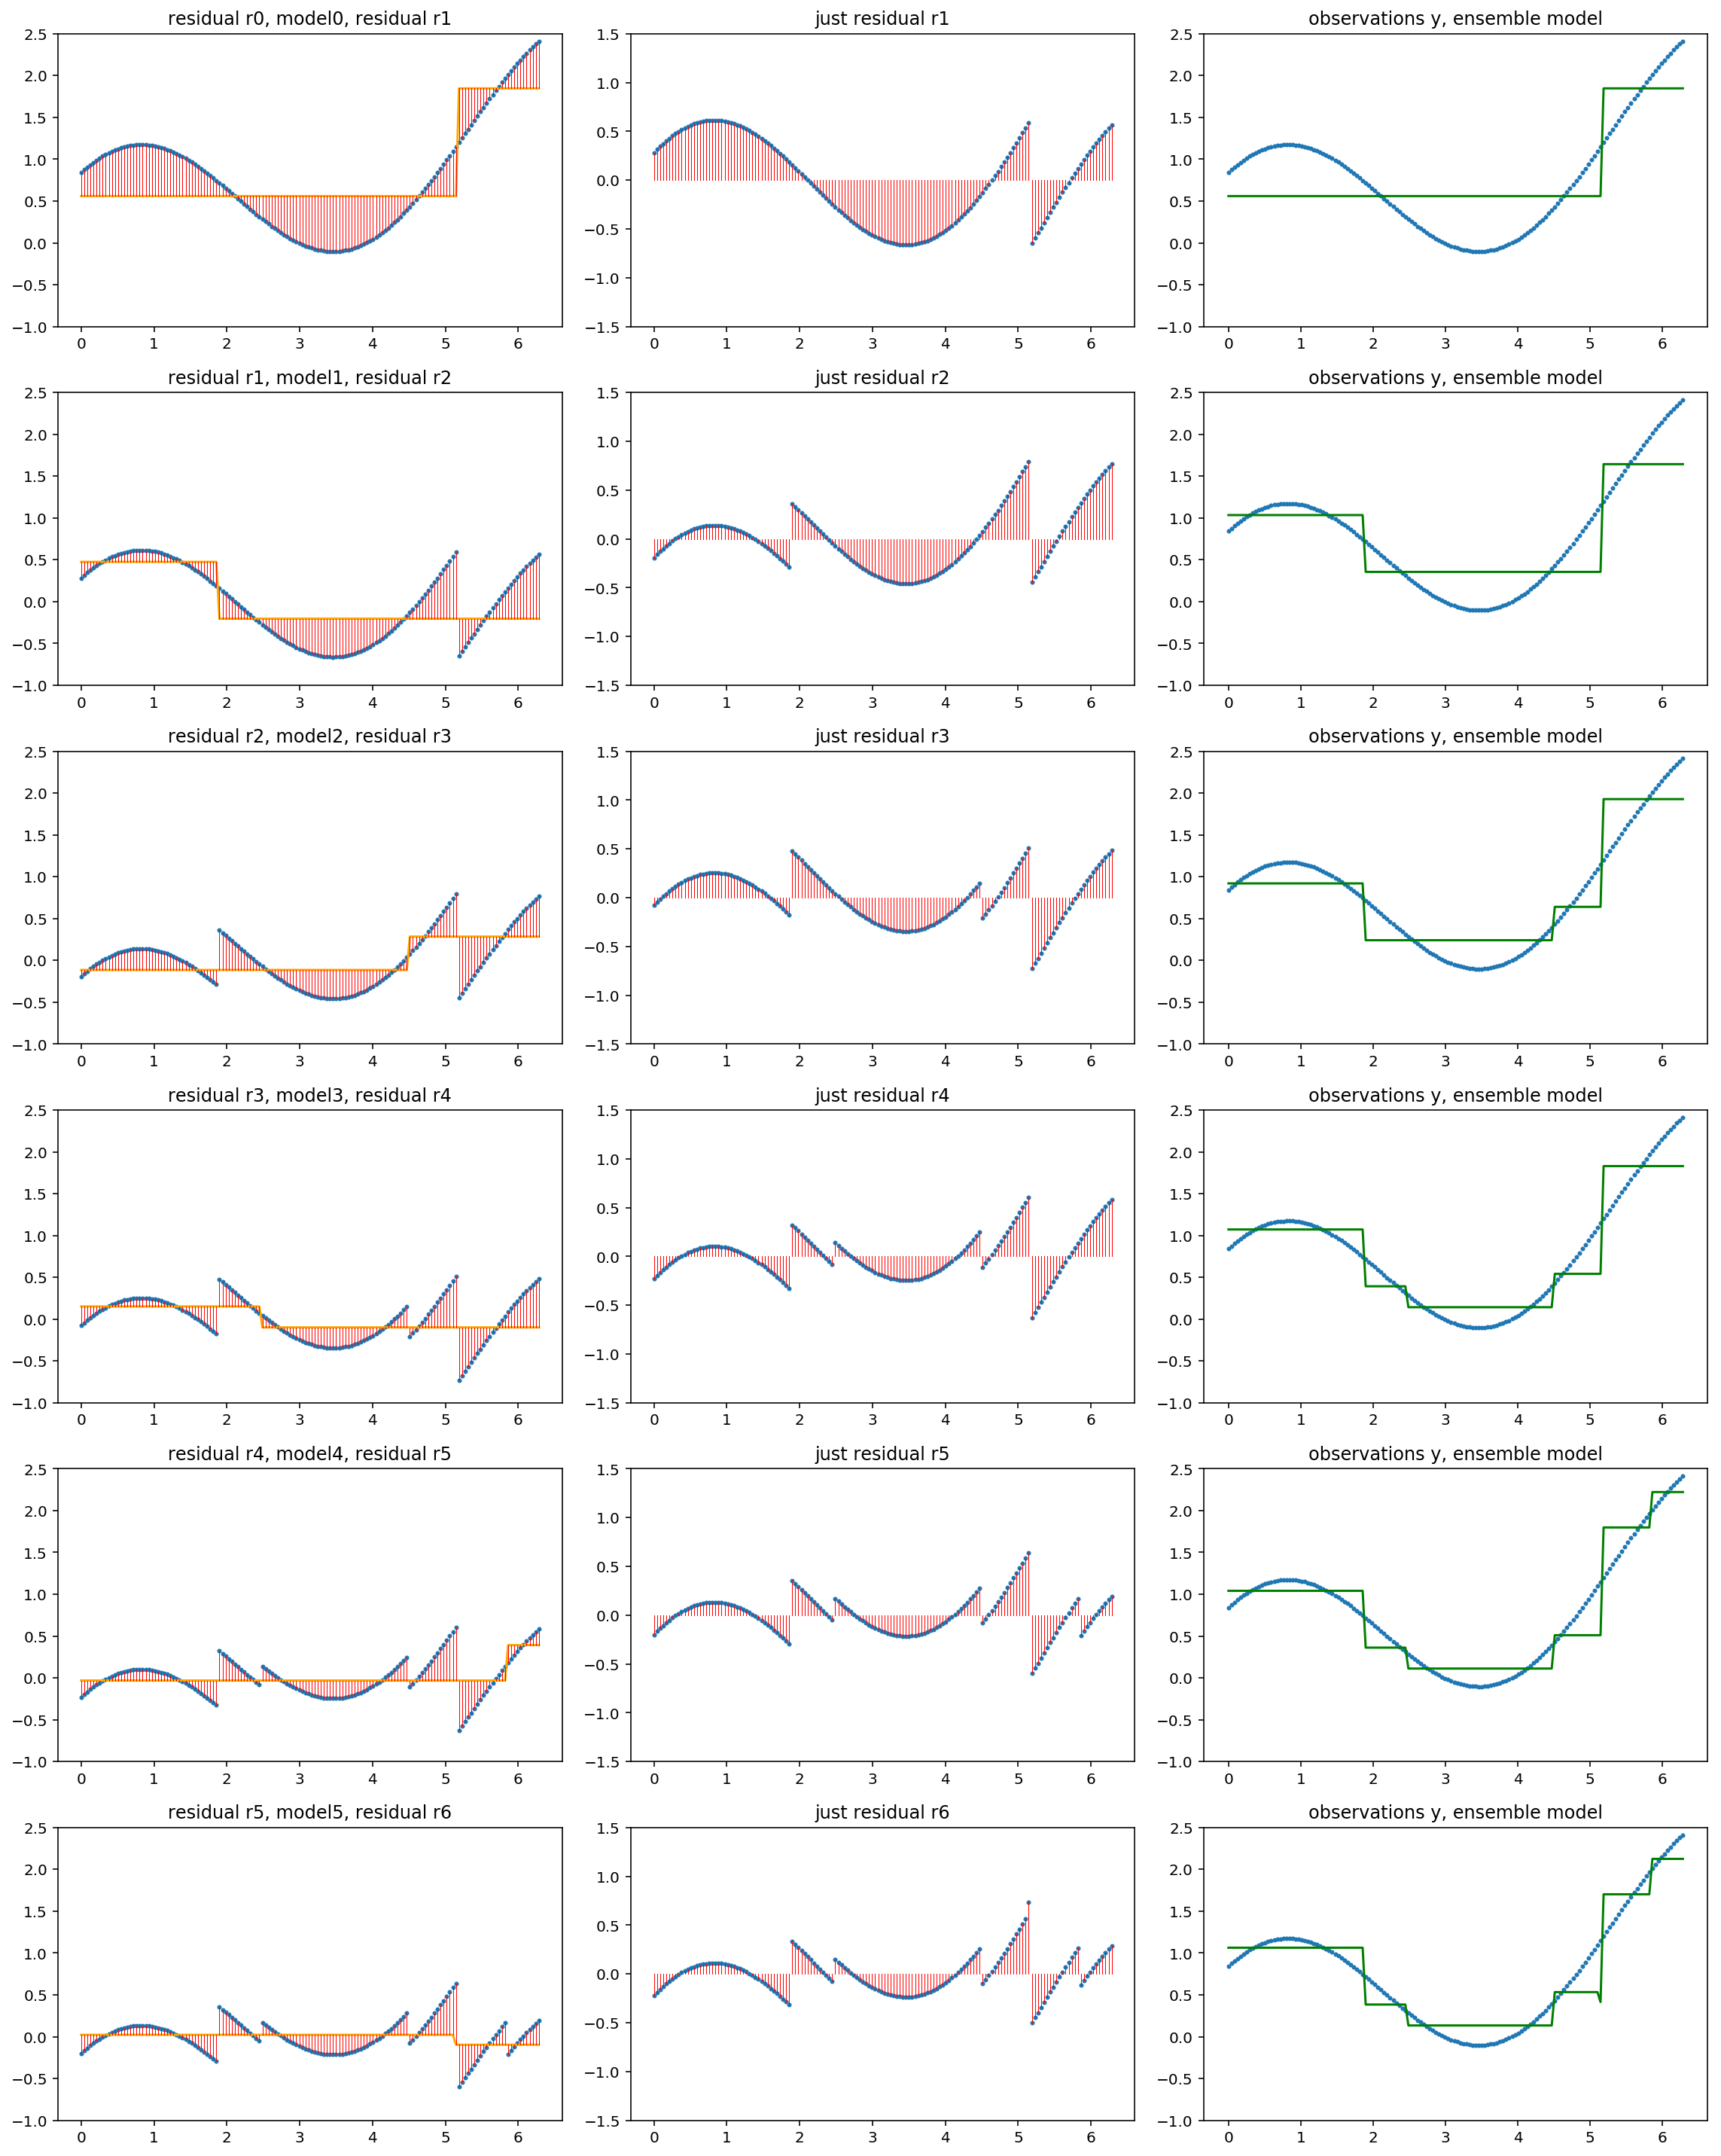

In [24]:
nrows = 6
fig, axs = plt.subplots(nrows, 3, figsize=(16,20))

yrange = (-1, 2.5)
rrange = (-1.5, 1.5)

r = y.copy()
ensemble = SequentialEnsemble()

# for each iteration
for i in range(nrows):
    # create stump model
    model = Stump()
    # fit it on last iteration's residuals
    model.fit(x,r)
    ensemble.add( model )
    
    # find the current iteration's residuals
    rhat = model.predict(x)
    r_next = r-rhat

    axs[i,0].scatter(x,r, s=4)
    axs[i,0].plot(x,rhat, c="orange")
    axs[i,0].set_ylim( yrange )
    axs[i,0].set_title("residual r%d, model%d, residual r%d"%(i,i,i+1))
    draw_residuals(x, r, rhat, ax=axs[i,0])

    axs[i,1].scatter(x, r_next, s=4)
    axs[i,1].set_ylim( rrange )
    axs[i,1].set_title("just residual r%d"%(i+1))
    draw_residuals( x, np.zeros_like(x), r_next, ax=axs[i,1] )

    # show the ensemble model
    yhat = ensemble.predict(x)
    axs[i,2].plot(x, yhat, c="green")
    axs[i,2].scatter(x,y, s=4)
    axs[i,2].set_ylim( yrange )
    axs[i,2].set_title("observations y, ensemble model")
    
    r = r_next
    
plt.tight_layout()
plt.show()


## Point achieved: Boosting is sequentially learning residuals

If all goes well we should be about 30 minutes into the lecture, but we're already at the point.

**Boosting is sequentially learning from error**. Everything else is mopping up the details.

Contrast with Random Forest (i.e. booststrap aggregation aka "Bagging"):
* Bagging: "the wisdom of the crowd"
* Boosting:  "learning from your mistakes"

Still left to cover:
* useful Python libraries
* gradients; learning rate
* boosting classification models

For the rest of the lecture, if you get lost, just come back here and look at the section title.



## Enter the GradientBoostingRegressor

`sklearn` provides a model class for boosted regression trees. With the parameters `max_depth=1` (which sets the constituent trees to stumps) and `learning_rate=1` (we'll get to that in a moment), it performs exactly as above.

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

Text(0.5, 1.0, 'GradientBoostingRegressor n_estimators=6, learning_rate=2, max_depth=1')

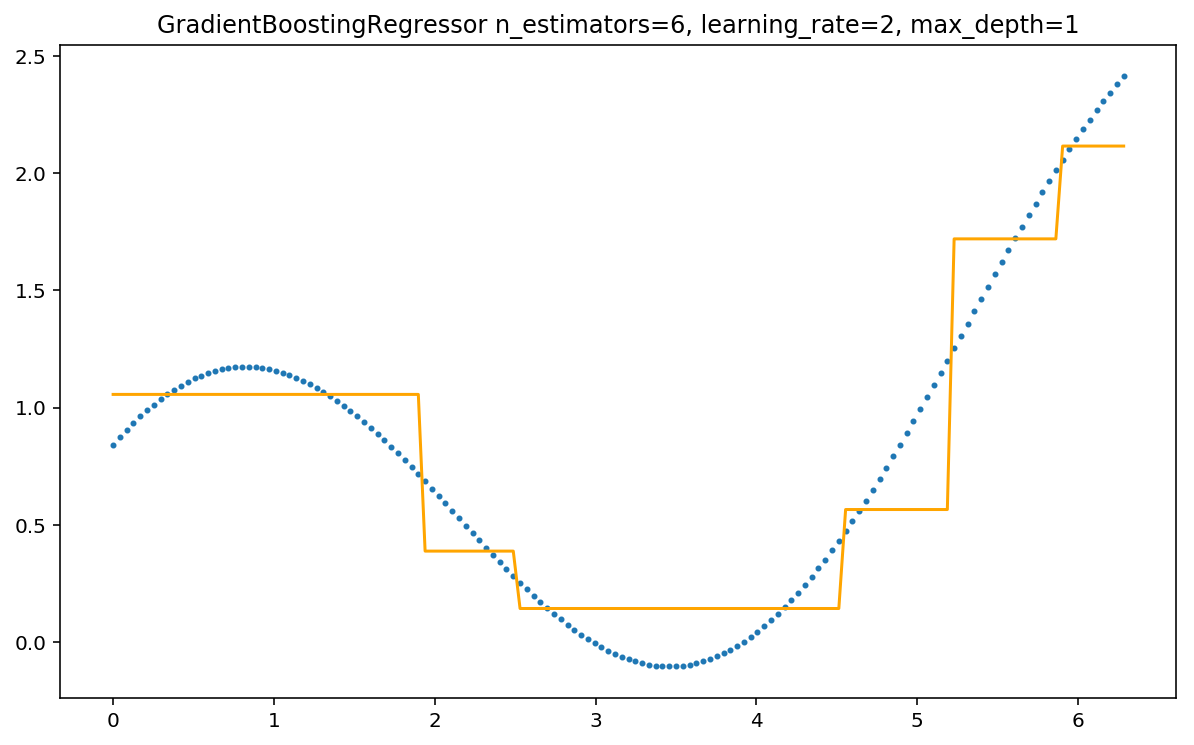

In [28]:
model = GradientBoostingRegressor(n_estimators=6, learning_rate=1, max_depth=1)
model.fit(x.reshape(-1,1),y)
yhat = model.predict(x.reshape(-1,1))

plt.figure(figsize=(10,6))
plt.plot(x,yhat,c="orange")
plt.scatter(x,y,s=4)
plt.title("GradientBoostingRegressor n_estimators=6, learning_rate=2, max_depth=1")

## Turning up GradientBoostingRegressor

Now that we have a tool to automate this work, we can just crank up the number of iterations to fit any curve? Right?

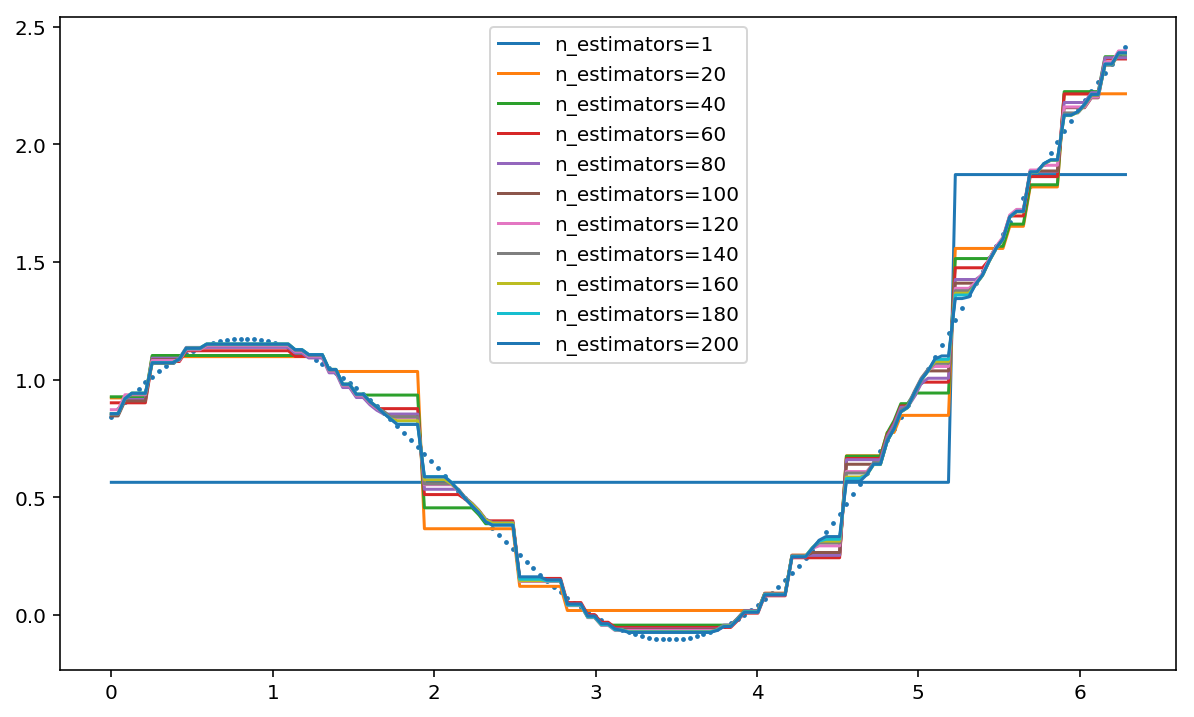

In [29]:
model = GradientBoostingRegressor(n_estimators=200, learning_rate=1, max_depth=1)
model.fit(x.reshape(-1,1),y)

plt.figure(figsize=(10,6))
plt.scatter(x,y, s=2)
for i, yhat in enumerate( model.staged_predict(x.reshape(-1,1)) ):
    if i!=0 and (i+1)%20!=0:
        continue
    
    plt.plot(x, yhat, label="n_estimators=%d"%(i+1))
plt.legend()

This is clearly **approaching** the latent function. Let's take a look at the model with 200 estimators:

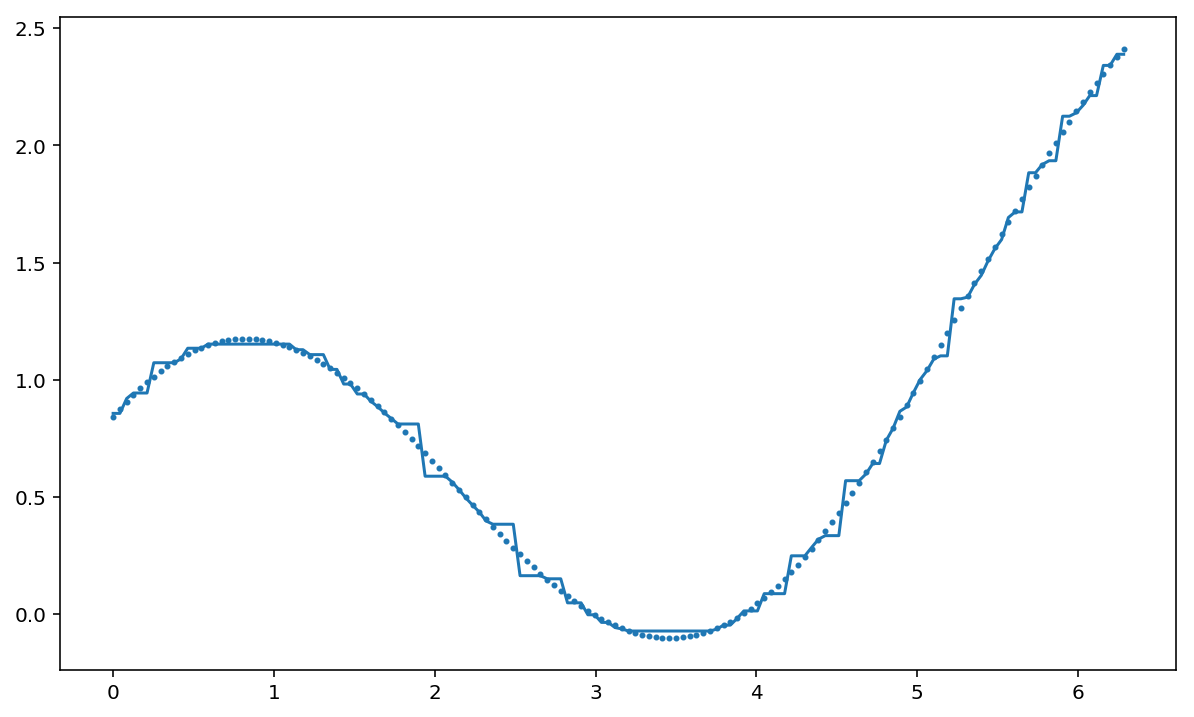

In [18]:
plt.figure(figsize=(10,6))
plt.plot(x,yhat)
plt.scatter(x,y, s=4)

It's converging _very slowly_, and after training an ensemble of 200 estimators it's still a pretty rough fit for the latent function. To address this, we need to take a look at the **learning rate**.

In [30]:
no_gradient_mse = mse( model.predict(x.reshape((-1,1))), y )
no_gradient_mse

0.0011793934808546924

## Putting the Gradient in GradientBoosting: the Learning Rate

Let's start back at the beginning, with a latent function, a decision tree stump, and the residuals.

This time, instead of finding residuals using the fit stump, we'll find the residuals using a **shrunken version** of the decision tree stump.

In [31]:
yc = y-y.mean() #data needs to be centered

r = yc.copy()

stump0 = Stump()
stump0.fit( x, r )
rhat = stump0.predict(x)

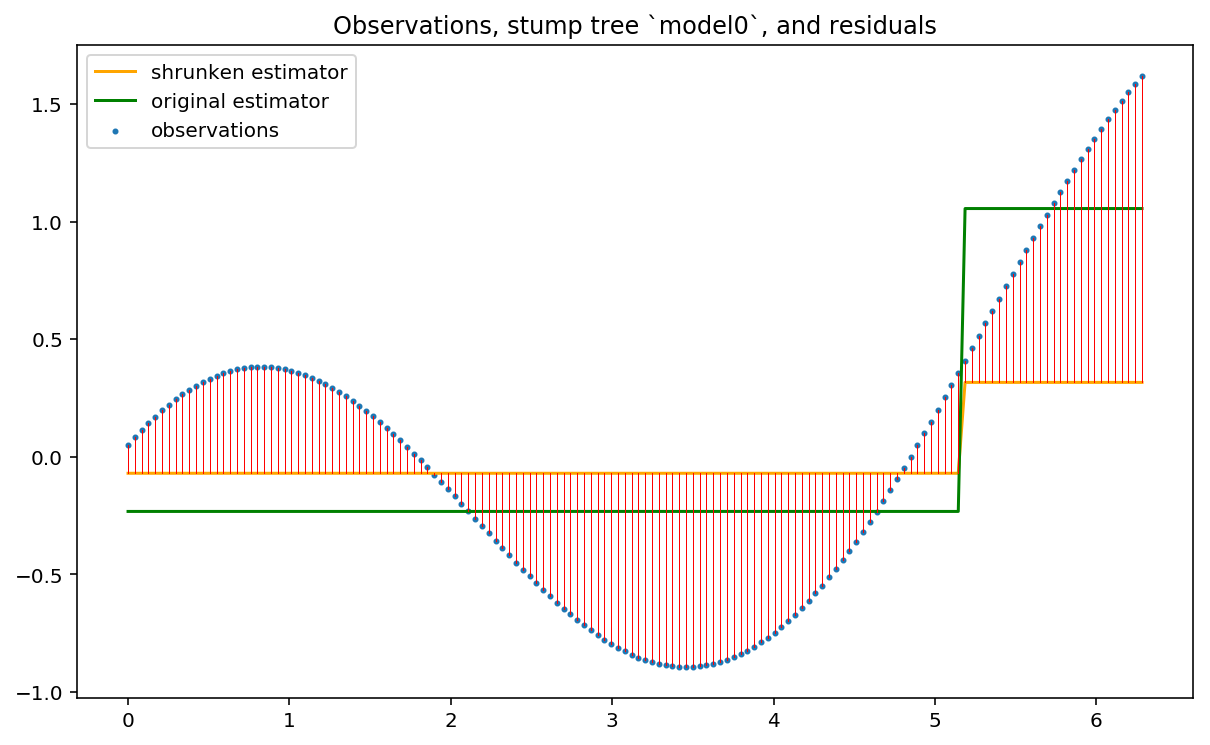

In [32]:
lam = 0.3 ##LOOKIE HERE

plt.figure(figsize=(10,6))
plt.scatter(x, yc, s=4, label="observations")
plt.plot(x, lam*rhat, c="orange", label="shrunken estimator")
plt.plot(x, rhat, c="green", label="original estimator")

draw_residuals(x, lam*rhat, yc)
plt.legend()
plt.title("Observations, stump tree `model0`, and residuals")

r = r-lam*rhat

At this point the process is familiar:
    
* Collect the residuals
* Fit a weak-learner estimate to them

Except now, like with last step, save a shrunken estimator and use it to update the residuals.

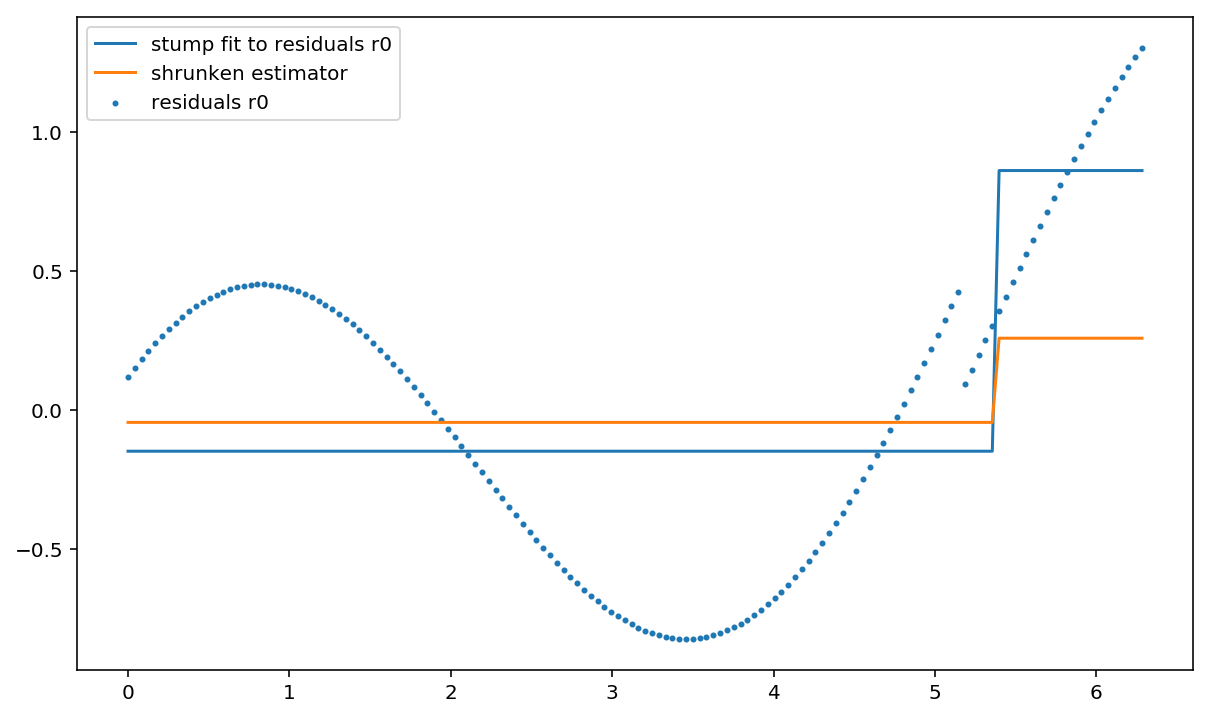

In [33]:
stump1 = Stump()
stump1.fit(x,r)
rhat = stump1.predict(x)

plt.figure(figsize=(10,6))
plt.scatter(x,r, s=4, label="residuals r0")
plt.plot(x,rhat, label="stump fit to residuals r0")
plt.plot(x,rhat*lam, label="shrunken estimator")
plt.legend()

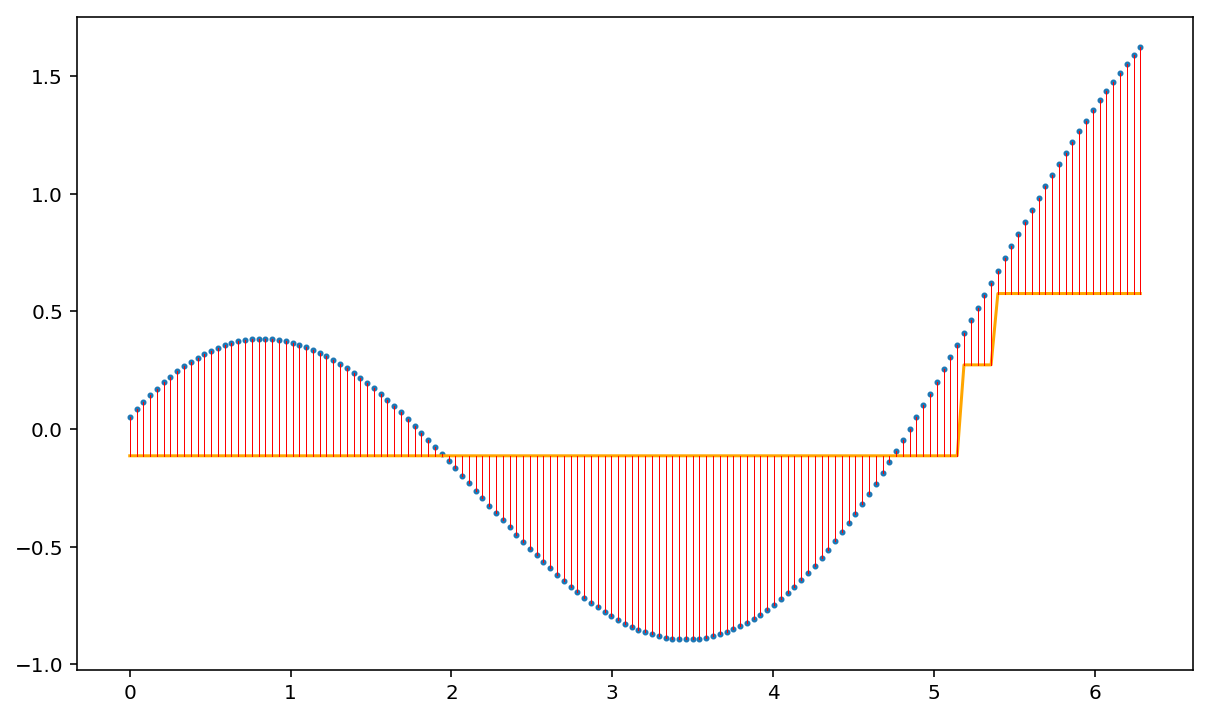

In [34]:
yhat = lam*(stump0.predict(x)+stump1.predict(x))

plt.figure(figsize=(10,6))
plt.plot( x, yhat, c="orange" )
plt.scatter( x, yc, s=4 )
draw_residuals(x, yc, yhat )

The idea is to **prevent overshooting** the latent function by moving in increments towards it. Instead, the weak learner moves towards the data in proportion to the residuals, following the **gradient of the residuals**.

The factor by which the weak learners are shrunk is called the **learning rate** $\lambda$. The learning rate modules convergence in a similar way to other gradient descent algorithms. Set the learning rate too low, and convergence will happen very slowly. Set the learning rate too high and the algorithm risks diverging.

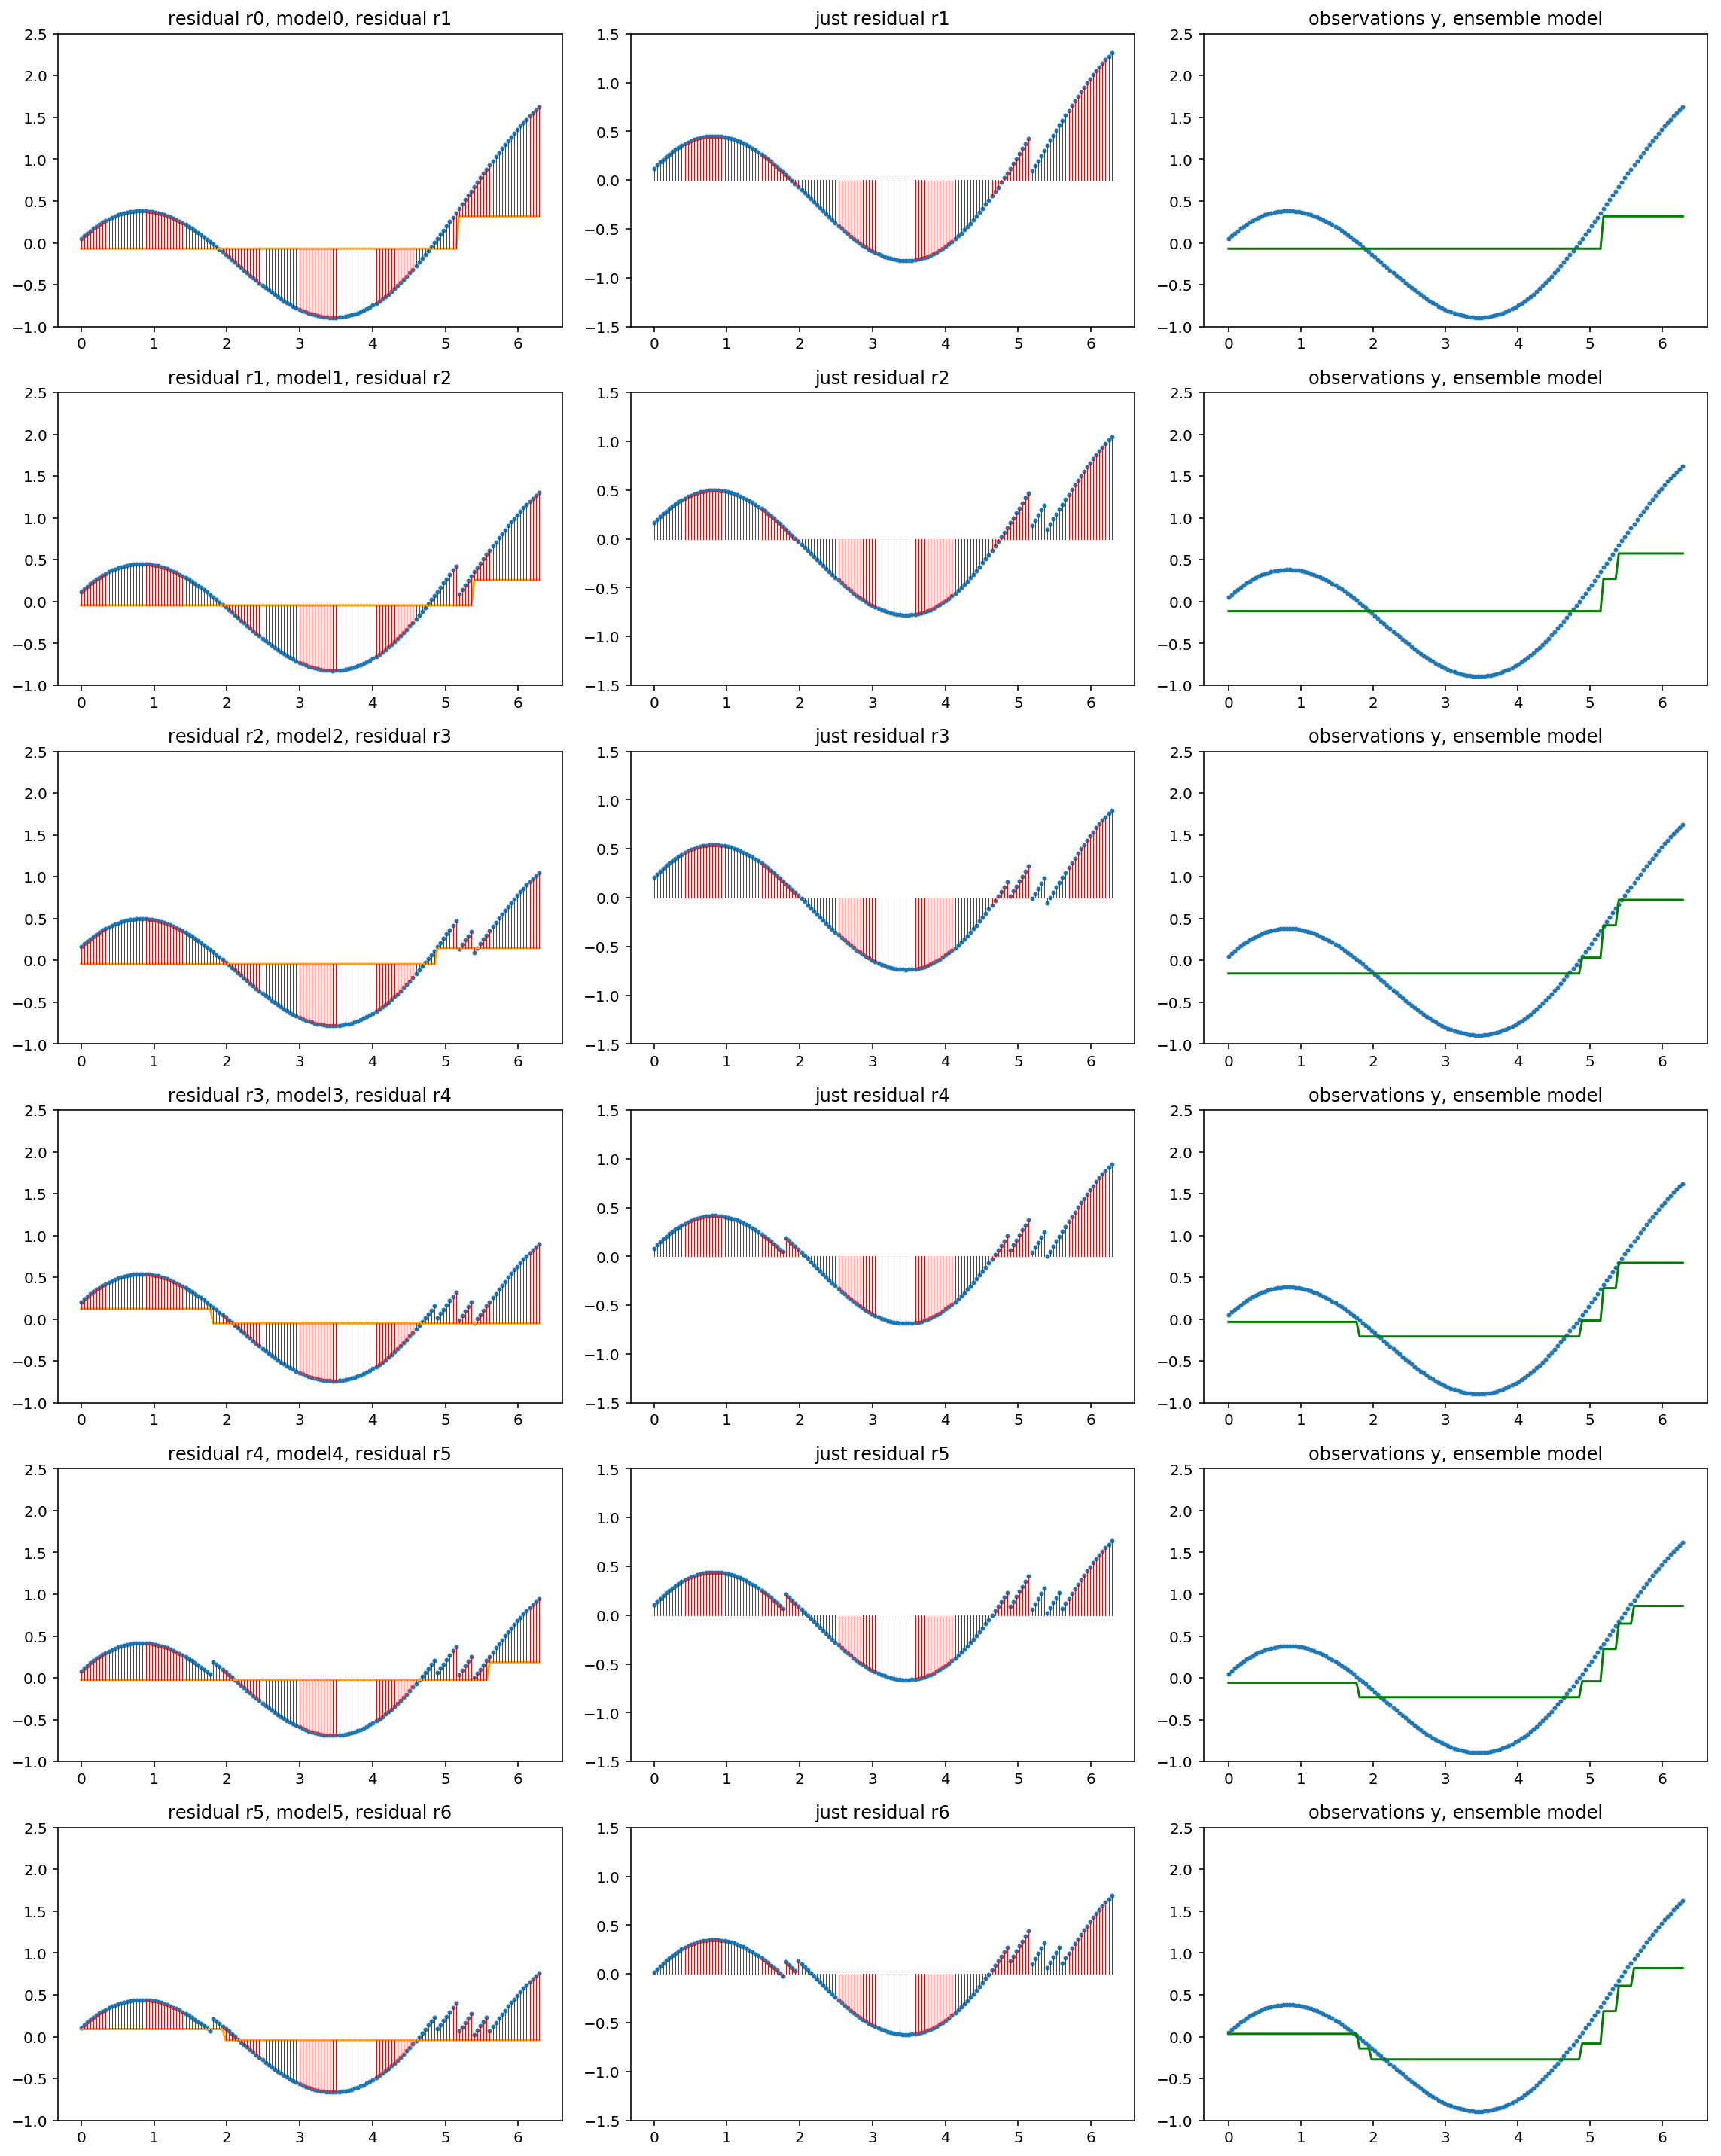

In [35]:
nrows = 6
fig, axs = plt.subplots(nrows, 3, figsize=(16,20))

yrange = (-1, 2.5)
rrange = (-1.5, 1.5)

yc = y - y.mean()
r = yc
ensemble = SequentialEnsemble()

lam = 0.3

# for each iteration
for i in range(nrows):
    # create stump model
    model = Stump()
    # fit it on last iteration's residuals
    model.fit(x,r)
    ensemble.add( model )
    
    # find the current iteration's residuals
    rhat = model.predict(x)
    r_next = r-lam*rhat

    axs[i,0].scatter(x,r, s=4)
    axs[i,0].plot(x,lam*rhat, c="orange")
    axs[i,0].set_ylim( yrange )
    axs[i,0].set_title("residual r%d, model%d, residual r%d"%(i,i,i+1))
    draw_residuals(x, r, lam*rhat, ax=axs[i,0])

    axs[i,1].scatter(x, r_next, s=4)
    axs[i,1].set_ylim( rrange )
    axs[i,1].set_title("just residual r%d"%(i+1))
    draw_residuals( x, np.zeros_like(x), r_next, ax=axs[i,1] )

    # show the ensemble model
    yhat = lam*ensemble.predict(x)
    axs[i,2].plot(x, yhat, c="green")
    axs[i,2].scatter(x,yc, s=4)
    axs[i,2].set_ylim( yrange )
    axs[i,2].set_title("observations y, ensemble model")
    
    r = r_next
    
plt.tight_layout()
plt.show()

Compare the lower-righthand plot above with the output of a fit GradientBoostingRegressor model below, with the same number of estimators and the same learning rate (and `max_depth=1` to ensure the ensembled models are stumps). They're the same - now you know how to implement `GradientBoostingRegressor`.

Text(0.5, 1.0, 'GradientBoostingRegressor n_estimators=6, learning_rate=0.30, max_depth=1')

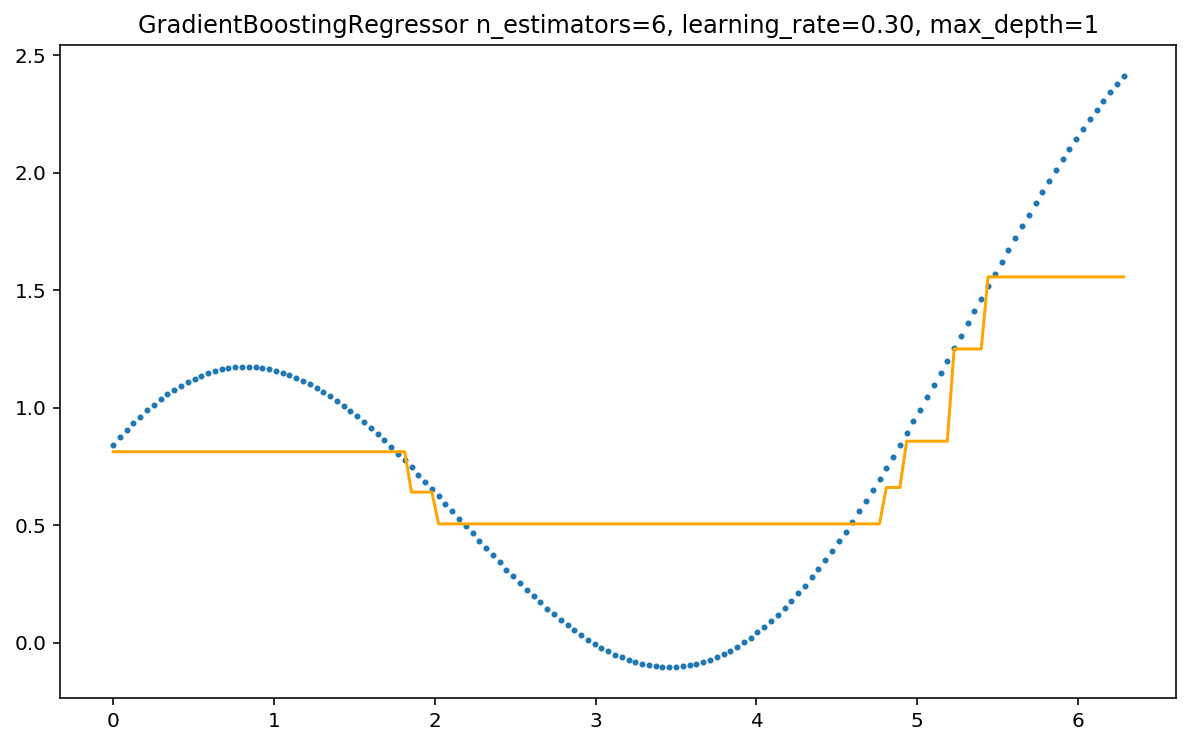

In [36]:
model = GradientBoostingRegressor(n_estimators=6, learning_rate=lam, max_depth=1)
model.fit(x.reshape(-1,1),y)
yhat = model.predict(x.reshape(-1,1))

plt.figure(figsize=(10,6))
plt.plot(x,yhat,c="orange")
plt.scatter(x,y,s=4)
plt.title("GradientBoostingRegressor n_estimators=6, learning_rate=%0.2f, max_depth=1"%lam)

## GradientBoostingRegressor learning rate and convergence

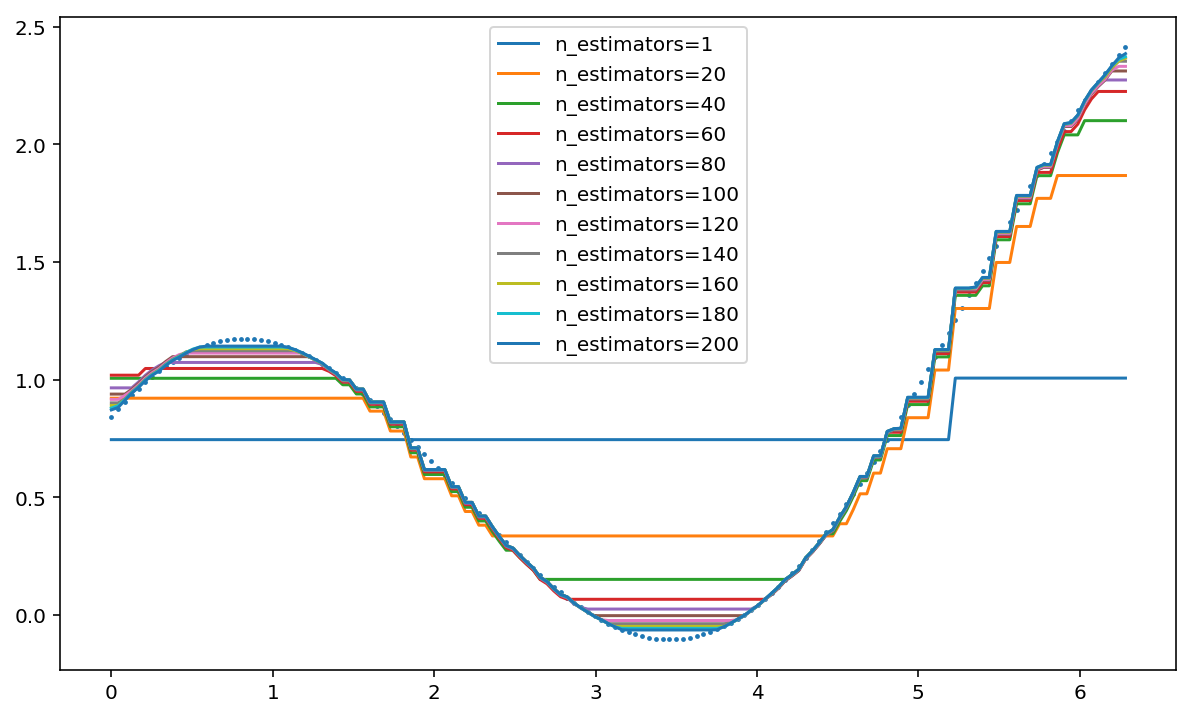

In [37]:
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.2, max_depth=1)
model.fit(x.reshape(-1,1),y)

plt.figure(figsize=(10,6))
plt.scatter(x,y, s=2)
for i, yhat in enumerate( model.staged_predict(x.reshape(-1,1)) ):
    if i!=0 and (i+1)%20!=0:
        continue
    
    plt.plot(x, yhat, label="n_estimators=%d"%(i+1))
plt.legend()

In [38]:
gradient_mse = mse( model.predict(x.reshape((-1,1))), y )
gradient_mse

0.0008017845128330056

In [40]:
gradient_mse / no_gradient_mse

0.6798278317190306

A lower learning rate leads to a modest boost in training error. Learning error is an important hyperparameter for fitting a gradient boosting ensemble.

The general rule of thumb is to start with a learning rate of about $\lambda=0.1$ and then turn the learning rate as low as you can given your training time budget.

## Gradient boosting: **extremely** effective

* Q: When should I use gradient boosting?
* A: Whenever model performance is key, train time is unconstrained, and interpretability is unimportant.

Given a long enough training time, a large carefully tuned gradient boosting model will usually outperform **any** other machine learning model. For that reason, gradient boosting (in particular, the `XGBoost` variant) has become very popular for Kaggle contests.

### A word of warning

It's not often the universe hands us an easy answer, but here we have one. How do I get the best predictive performance? Spin up \\$500 worth of EC2 machines and grid-search XGBoost parameters for a couple days.

However: **don't become an XGBoost grid-search babysitter**.

It's boring. Any fool can do it. It doesn't give interesting answers; just razor-thin incrementally better predictions.

The job of a data scientist is to **quickly** turn **poorly posed questions** and **dirty datasets** into **interpretable, actionable answers**. A gigantic XGBoost model won't help you do *any* of those things.



## Boosting for Classification

Simplest dumb thing: just use do boosted regression on the classes, interpret output as probabilities.

Here's a toy dataset, where `X` has one feature: `latitude`, and the `y` is a binary feature `is_polar_bear`. Data points are observations of bears.

Text(0, 0.5, 'polar bear?')

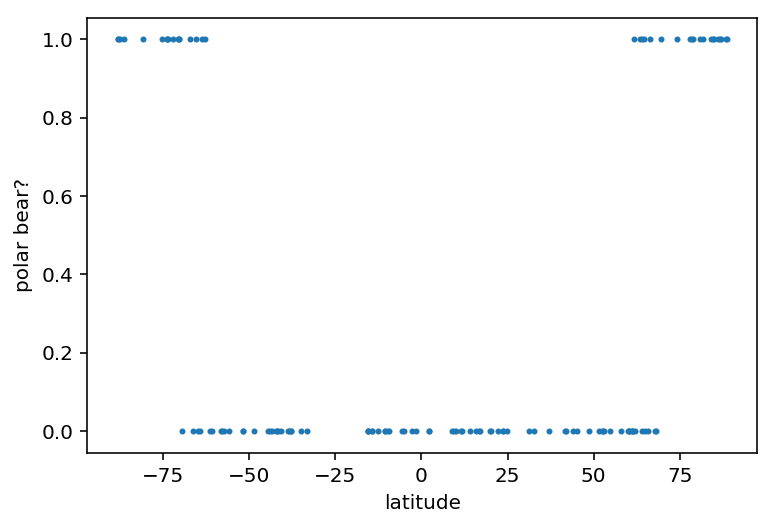

In [42]:
np.random.seed(42)

sbears = np.random.uniform(-90,-60, size=30*10)
nbears = np.random.uniform(60, 90, size=30*10)
midbears = np.random.uniform(-70,70,size=70*2*10)
x = np.concatenate((sbears,midbears,nbears))
y = np.concatenate((np.ones_like(sbears), np.zeros_like(midbears), np.ones_like(nbears)))

i = np.argsort(x)
x = x[i]
y = y[i]

isample = np.random.choice( range(len(x)), size=120 )
plt.scatter(x[isample],y[isample], s=4)
plt.xlabel("latitude")
plt.ylabel("polar bear?")

Split the dataset into train/test, and then simply train a regression model.

In [43]:
X = x.reshape((-1,1))
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [44]:
model = GradientBoostingRegressor() #straight out of the box
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

The resultant output works well interpreted as a soft binary classifier.

Text(0.5, 1.0, 'Classification via GradientBoostinRegressor')

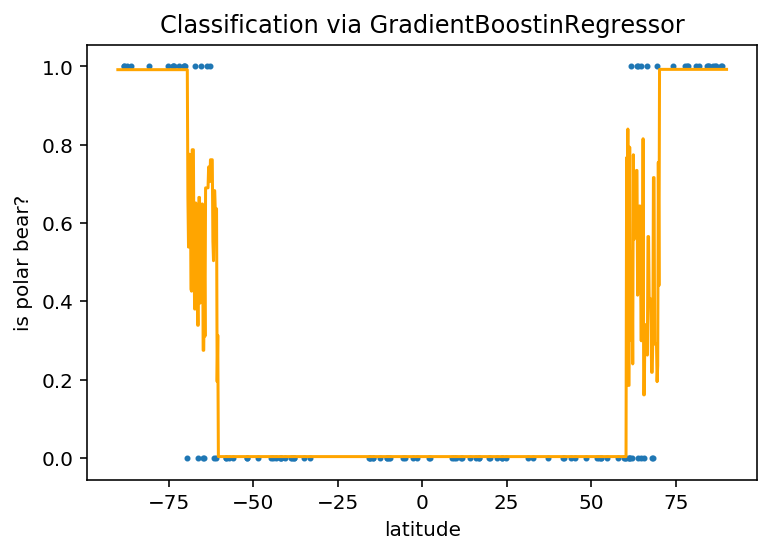

In [45]:
xspace = np.linspace(-90,90,num=1000)
yhat = model.predict(xspace.reshape((-1,1)))

plt.plot(xspace, yhat, c="orange")
plt.scatter(x[isample],y[isample], s=4)
plt.xlabel("latitude")
plt.ylabel("is polar bear?")
plt.title("Classification via GradientBoostinRegressor")

In [46]:
roc_auc_score( y_test, model.predict(X_test) )

0.9793651693889897

Works surprisingly well. In fact, GradientBoostedClassification does probability regression using the same loss function as logistic regression.

Text(0, 0.5, 'is polar bear?')

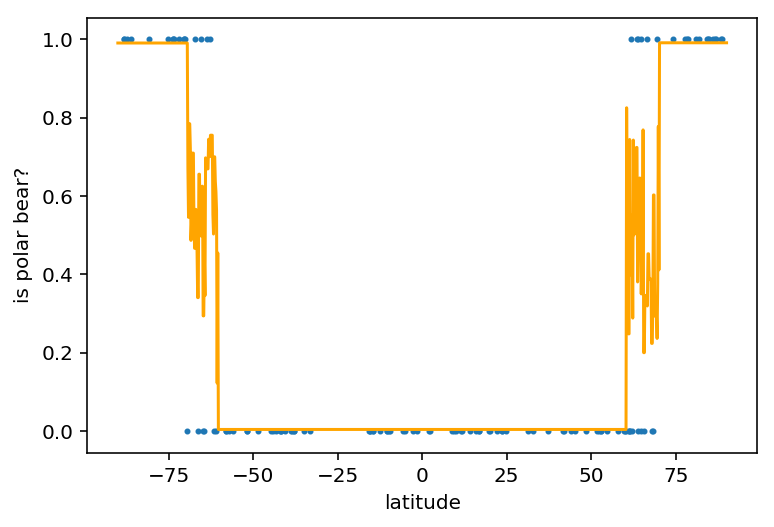

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

classmodel = GradientBoostingClassifier()
classmodel.fit(X_train, y_train)

yhat = classmodel.predict_proba(xspace.reshape((-1,1))).T[1]

plt.plot(xspace, yhat, c="orange")
plt.scatter(x[isample],y[isample], s=4)
plt.xlabel("latitude")
plt.ylabel("is polar bear?")

In [48]:
roc_auc_score( y_test, classmodel.predict_proba(X_test).T[1] )

0.9794596944948578

In this case it least, the two approaches are functionally equivalent.

# Afternoon - AdaBoost, Partial Dependence Plots

## Classification with Boosting: AdaBoost

The scaffolding of Boosting is unchanged:

* Initialize the error to the observations.
* At each stage we fit to the error.
* Each iteration's model has a weight in the final ensemble.

Here's the specifics:

For $N$ observations, and $M$ models .

1. Initialize the observation weights $w_i = 1/N$; $i=i,2,3 \ldots N$.
2. For $m=1$ to $M$:
    1. Fit a classifier $G_m(x)$ to the training data using weights $\vec{w}$.
    2. Compute the weighted fraction of predictions we got wrong.
    
    $$err_m=\frac{\sum_{i=1}^{N} w_i I(y_i \neq G_m(x_i)) }{\sum_{i=1}^{N} w_i } $$
    
    3. Convert the error into model weighting term $\alpha_m$
    
    $$\alpha_m = \log(\frac{1-err_m}{err_m})$$
    
    Sometimes this terms appears with a $1/2$ factor; it doesn't change the eventual conclusion.
    
    4. Update sample weights
    
    $$w_i \leftarrow w_i \exp[\alpha_m I(y_i \neq G_m(x_i))]$$
    
    note that this is the same as
    
    $$w_i \leftarrow w_i (\frac{1-err_m}{err_m})^{I(y_i \neq G_m(x_i))}$$
    
    or
    
      * $w_i \leftarrow w_i (\frac{1-err_m}{err_m}) $ when prediction incorrect
      * $w_i \leftarrow w_i$ when prediction correct
    
    Which is simpler to understand but more complex to implement in code.
3. The ensemble output is

$$G(x) = sign[\sum_{m=1}^{M} \alpha_m G_m(x)]$$


Text(0, 0.5, '$\\alpha_m$')

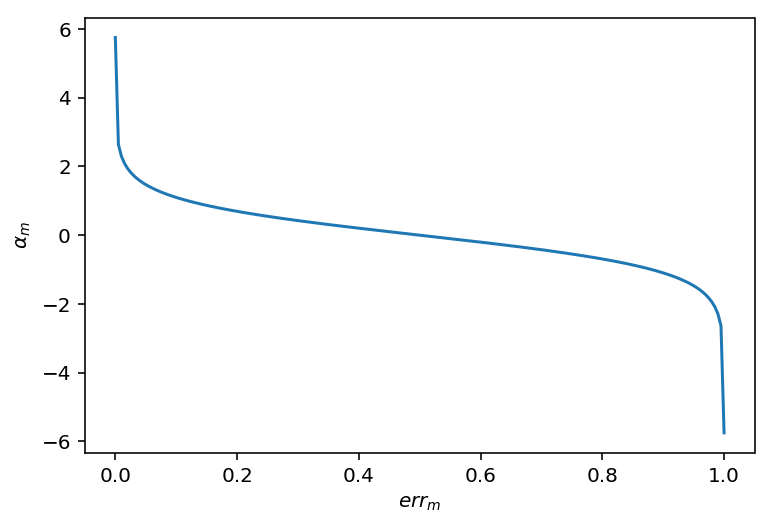

In [60]:
err_m = np.linspace(0.00001, 0.99999, num=200)
alpha_m = 0.5*np.log((1-err_m)/err_m)
plt.plot(err_m, alpha_m)
plt.xlabel("$err_m$")
plt.ylabel("$\\alpha_m$")

Text(0, 0.5, '$\\exp[\\alpha_m]$')

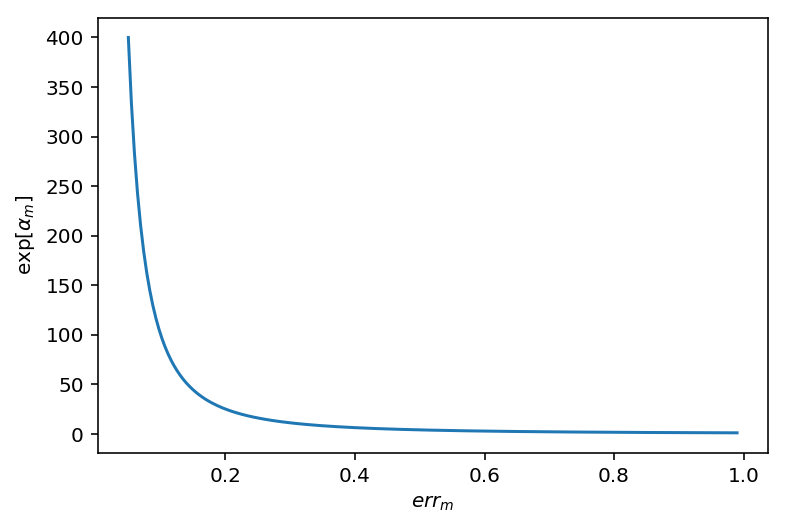

In [66]:
err_m = np.linspace(0.05, 0.99, num=200)
plt.plot(err_m, (1/err_m)/err_m)
plt.xlabel("$err_m$")
plt.ylabel("$\exp[\\alpha_m]$")

A demonstration, via a toy dataset:

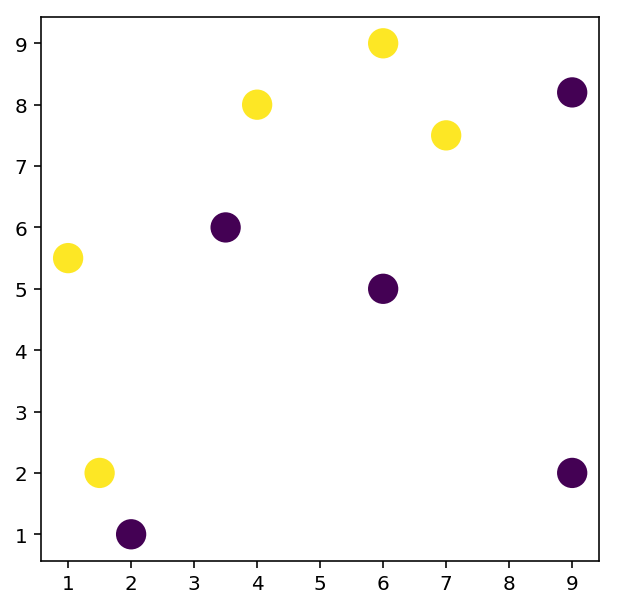

In [67]:
from sklearn.tree import DecisionTreeClassifier

X = [[4,8],
     [6,9],
     [7,7.5],
     [9,8.2],
     [1,5.5],
     [3.5,6],
     [6,5],
     [1.5,2],
     [2,1],
     [9,2]]
X = np.array(X)
y = np.array([1,1,1,-1,1,-1,-1,1,-1,-1])

plt.figure(figsize=(5,5))
plt.scatter( X.T[0], X.T[1], c=y, s=200 )

### Round 1

Make default weights $w$.

In [68]:
w_1= np.ones_like(y)/len(y)
w_1

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

Fit first decision tree stump.

In [69]:
G_1 = DecisionTreeClassifier(max_depth=1)
G_1.fit(X,y, sample_weight=w_1)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Find $I(y_i \neq G_1(x_i))$, a boolean vector of where 1 corresponds to incorrect predictions

In [70]:
incorrect = (G_1.predict(X) != y).astype(int)
incorrect

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

Find weighted fraction of incorrect predictions. In the first round, it's 3/10.

In [88]:
err_1 = (incorrect*w_1).sum()/w_1.sum()
err_1

0.30000000000000004

Convert that into a model weight. $G_1$ got more than half right, which earns us a positive weight factor.

In [104]:
alpha_1 = 0.5*np.log( ( 1-err_1 )/err_1 )
alpha_1

0.4236489301936017

This corresponds to a residual weighting factor of:

In [112]:
np.exp(alpha_1)

1.5275252316519465

Meaning all observation weights of miscategorized observations will be bumped by that factor.

In [114]:
w_2 = w_1*np.exp( alpha_1*incorrect )
w_2

array([0.15275252, 0.15275252, 0.15275252, 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ])

Let's take a look at a visualization of the stump-model, the true labels of the observations, and the current weights of the observations.

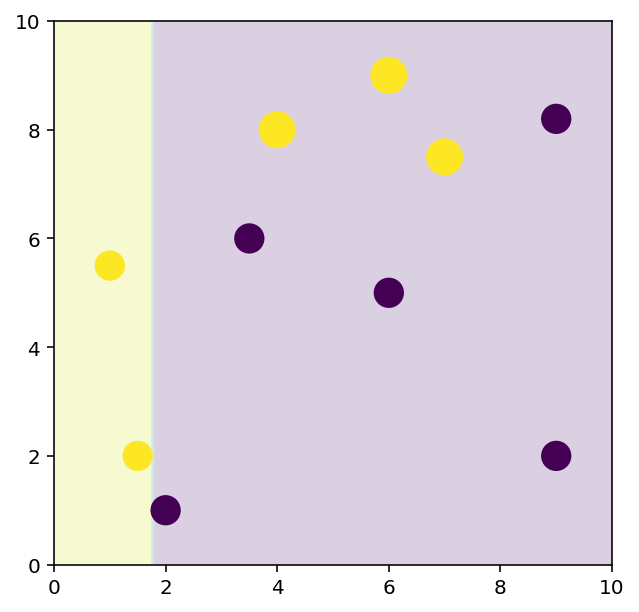

In [116]:
m, n = 100, 100
xx1, xx2 = np.meshgrid(np.linspace(0,10,m), np.linspace(0,10,n))
pred_1 = G_1.predict( np.stack( (xx1.ravel(), xx2.ravel()) ).T ).reshape((m,n))

plt.figure(figsize=(5,5))
plt.contourf(xx1, 
             xx2, 
             pred_1, alpha=0.2 )
plt.scatter( X.T[0], X.T[1], c=y, s=w_2*2000 )

### Round 2

Fit a stump with the new observation weights.

In [117]:
G_2 = DecisionTreeClassifier(max_depth=1)
G_2.fit(X,y, sample_weight=w_2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Find $I(y_i \neq G_2(x_i))$.

In [118]:
incorrect = (G_2.predict(X) != y).astype(int)
incorrect

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0])

Find the weighted fraction we got wrong.

In [120]:
err_2 = (incorrect*w_2).sum()/w_2.sum()
err_2

0.25900974696901713

Better than 0.5 means positive model weighting factor $\alpha_2$.

In [121]:
alpha_2 = 0.5*np.log( ( 1-err_2 )/err_2 )
alpha_2

0.525560888664397

This corresponds to the factor by which the importance of an incorrectly categorized observation will be inflated:

In [124]:
np.exp(alpha_2)

1.6914072735403736

Perform that observation re-weighting.

In [125]:
w_3 = w_2*np.exp( alpha_2*incorrect )
w_3

array([0.15275252, 0.15275252, 0.15275252, 0.1       , 0.1       ,
       0.16914073, 0.16914073, 0.1       , 0.16914073, 0.1       ])

Note the three mis-categorized dark spots in the left, now amplified for the next round.

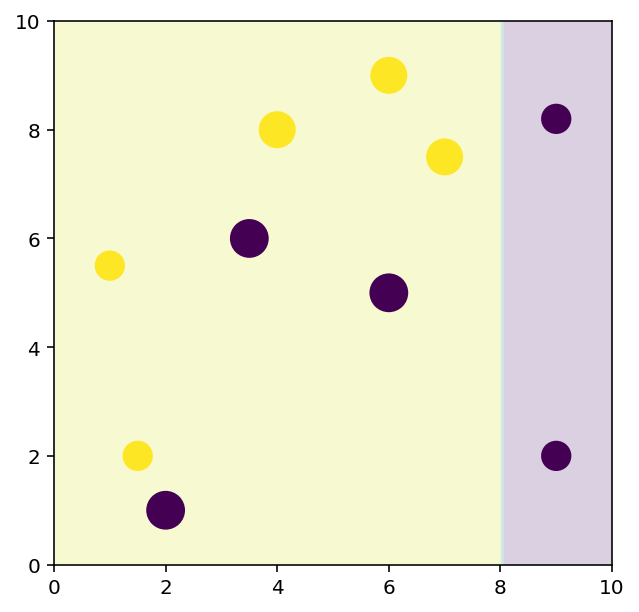

In [127]:
m, n = 100, 100
xx1, xx2 = np.meshgrid(np.linspace(0,10,m), np.linspace(0,10,n))
pred_2 = G_2.predict( np.stack( (xx1.ravel(), xx2.ravel()) ).T ).reshape((m,n))

plt.figure(figsize=(5,5))
plt.contourf(xx1, 
             xx2, 
             pred_2, alpha=0.2 )
plt.scatter( X.T[0], X.T[1], c=y, s=w_3*2000 )

### Round 3

Fit a brand-new decision stump.

In [128]:
G_3 = DecisionTreeClassifier(max_depth=1)
G_3.fit(X,y, sample_weight=w_3)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Find $I(y_i \neq G_3(x_i))$.

In [130]:
incorrect = (G_3.predict(X) != y).astype(int)
incorrect

array([0, 0, 0, 1, 1, 0, 0, 1, 0, 0])

Find the weighted error rate. Again, we got three wrong, but they weren't the most important so our error rate is only about 0.22.

In [132]:
err_3 = (incorrect*w_3).sum()/w_3.sum()
err_3

0.21967082667647347

Model weight is positive.

In [135]:
alpha_3 = 0.5*np.log( ( 1-err_3 )/err_3 )
alpha_3

0.6337928321283368

Inflation factor for miscategorized observations.

In [136]:
np.exp(alpha_3)

1.8847455633388963

In [137]:
w_4 = w_3*np.exp( alpha_3*incorrect )
w_4

array([0.15275252, 0.15275252, 0.15275252, 0.18847456, 0.18847456,
       0.16914073, 0.16914073, 0.18847456, 0.16914073, 0.1       ])

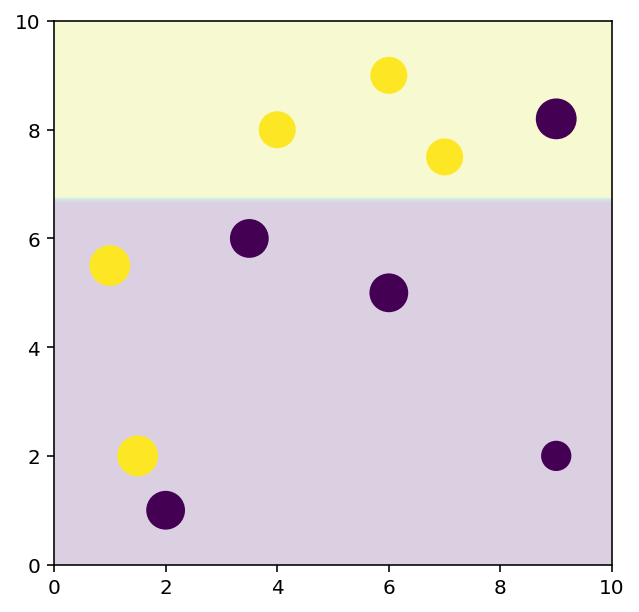

In [138]:
m, n = 100, 100
xx1, xx2 = np.meshgrid(np.linspace(0,10,m), np.linspace(0,10,n))
pred_3 = G_3.predict( np.stack( (xx1.ravel(), xx2.ravel()) ).T ).reshape((m,n))

plt.figure(figsize=(5,5))
plt.contourf(xx1, 
             xx2, 
             pred_3, alpha=0.2 )
plt.scatter( X.T[0], X.T[1], c=y, s=w_4*2000 )

array([-1, -1, -1, -1,  1, -1, -1,  1, -1, -1])

## Ensemble it!

Text(0.5, 1.0, '$G_3, \\alpha_3=0.63$')

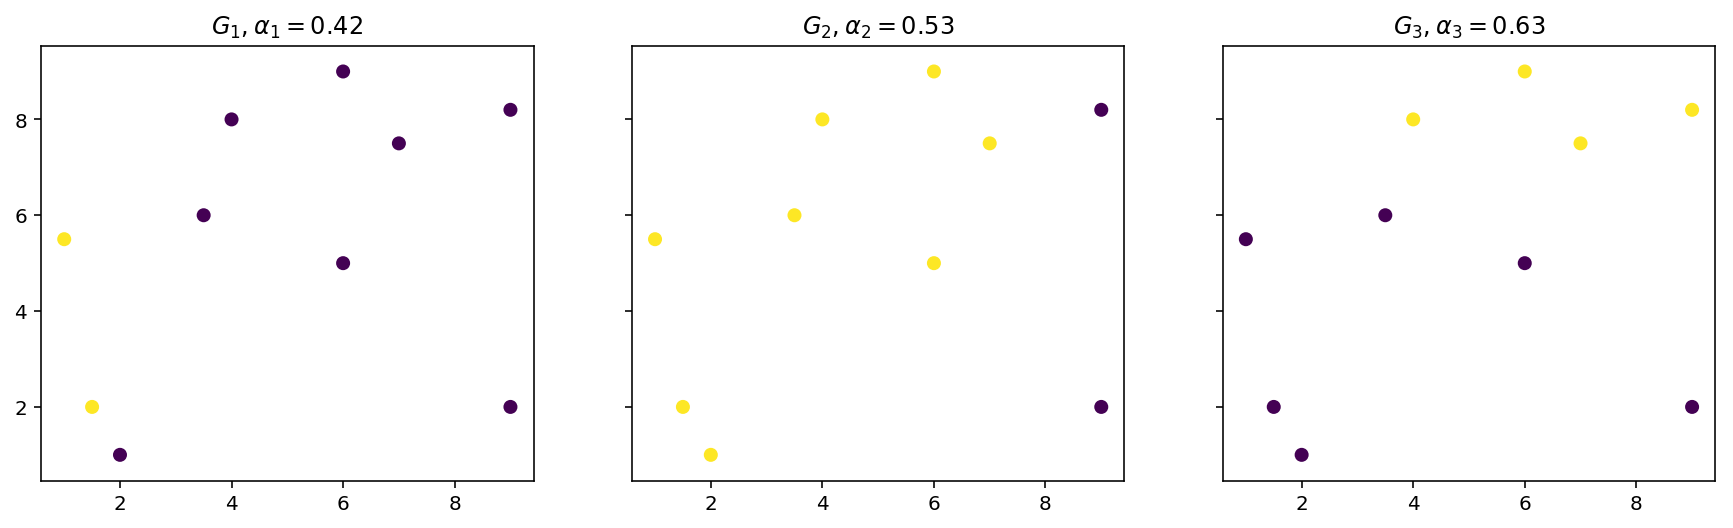

In [163]:
fig, ax = plt.subplots(1,3, figsize=(15,4), sharey=True)
ax[0].scatter(X.T[0], X.T[1], c=G_1.predict(X))
ax[1].scatter(X.T[0], X.T[1], c=G_2.predict(X))
ax[2].scatter(X.T[0], X.T[1], c=G_3.predict(X))

ax[0].set_title("$G_1, \\alpha_1=%0.2f$"%alpha_1)
ax[1].set_title("$G_2, \\alpha_2=%0.2f$"%alpha_2)
ax[2].set_title("$G_3, \\alpha_3=%0.2f$"%alpha_3)


Weighted voting:

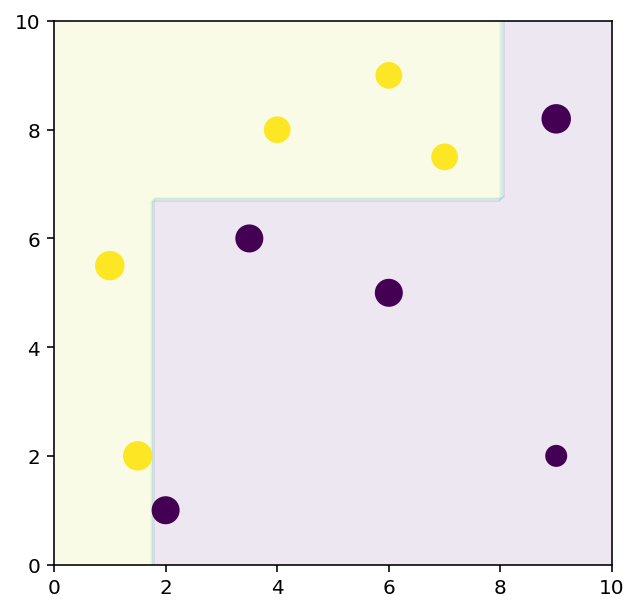

In [164]:
pred_ensemble = (alpha_1*pred_1 + alpha_2*pred_2 + alpha_3*pred_3)>0

plt.figure(figsize=(5,5))
plt.contourf( xx1, xx2, pred_ensemble, alpha=0.1 )
plt.scatter( X.T[0], X.T[1], c=y, s=w_4*1000 )

Though invented before Gradient Boosting, this turns out to be a special subset of the residual-weighting strategy embodied in the Gradient Boosting algorithm.

## Partial Dependence Plots

What is the effect on the target of a single feature?

e.g.: How does room count influence home price?

With linear models: just $\beta_{room}$.

Not as clear with ensemble models.

In [78]:

from sklearn import datasets
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

## Regression on the boston data set
N_ESTIMATORS = 3000

boston = datasets.load_boston()
X, y, names = boston['data'], boston['target'], boston['feature_names']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

model = GradientBoostingRegressor(n_estimators=N_ESTIMATORS, learning_rate=0.01)
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3000, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [79]:
boston['feature_names'][5]

'RM'

Text(0.5, 1.0, 'Rooms vs price scatter plot, Boston dataset')

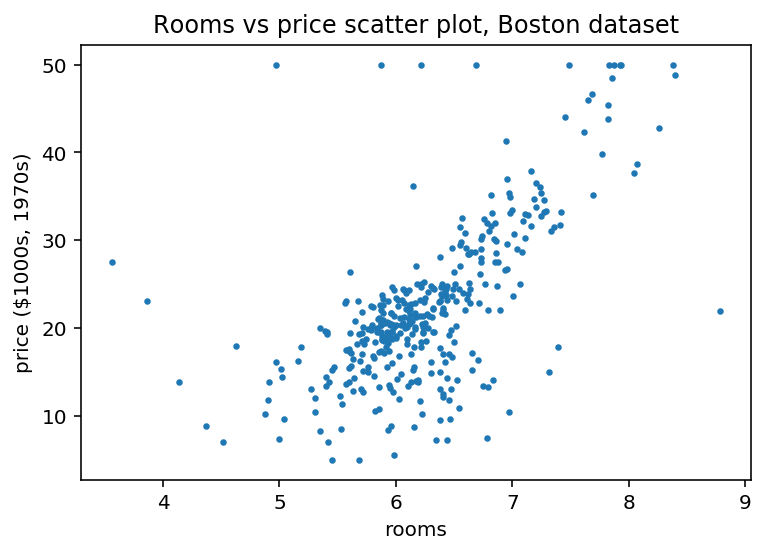

In [80]:
plt.scatter( X_train[:,5], y_train, s=5 )
plt.xlabel("rooms")
plt.ylabel("price ($1000s, 1970s)")
plt.title("Rooms vs price scatter plot, Boston dataset")

In [81]:
Xp = X_train.copy()
Xp[:5] = 6 #right in the middle

In [82]:
model.predict(Xp).mean() # right in the middle

22.4447887211805

In [90]:
rooms = np.linspace(4,9)
prices = []
for room in rooms:
    Xp = X_train.copy()
    Xp[:,5] = room
    mean_price = model.predict(Xp).mean()
    prices.append( mean_price )

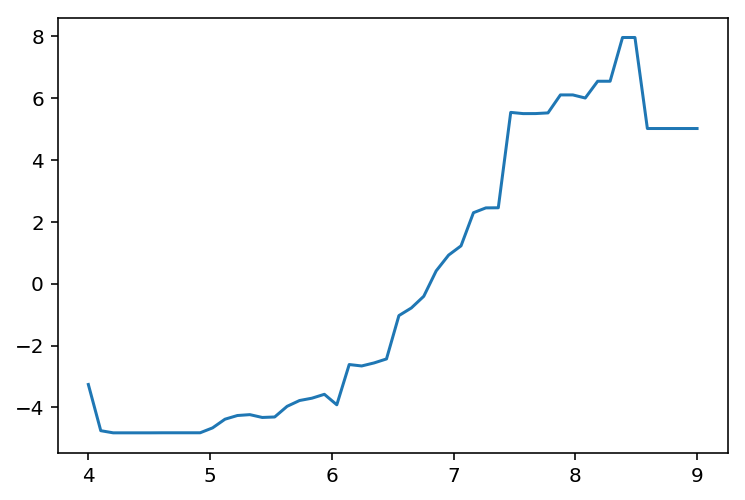

In [96]:
plt.plot( rooms, prices-np.array(prices).mean() )

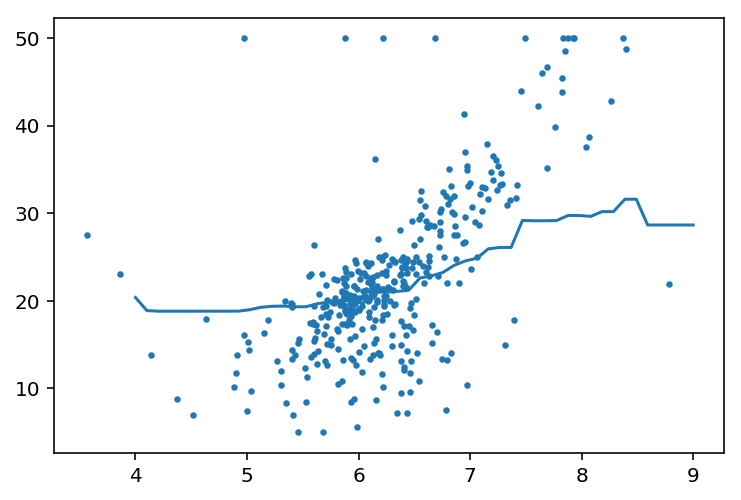

In [97]:
plt.plot( rooms, prices )
plt.scatter( X_train[:,5], y_train, s=5 )

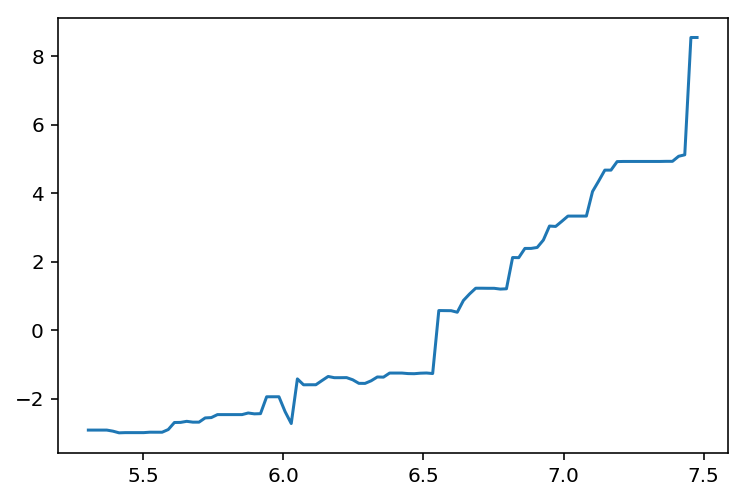

In [98]:
a, b = partial_dependence(model, 5, X=X_train)
plt.plot(b[0], a[0])